In [1]:
from __future__ import print_function, division
import os, bz2, json, time, tqdm
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import my_util

In [2]:
# import importlib
# importlib.reload(my_util)

In [3]:
categories = ["activism","autos","comedy","education","entertainment", \
              "film","gaming","howto","movies","music",\
              "news","people","pets","science","shows",\
              "sports","trailers","travel"]

categories_eligible = ["autos","comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

eval_days = [90, 135, 180, 225, 270]

In [4]:
# dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos" 
# dataset_base = "G:/MLCV dataset/engagement'16/quality_videos"
dataset_base = "/Users/zhuxinqi/Documents/online_attention/engagement'16/tweeted_videos"
test_category = categories_eligible[8]
# test_category = "howto"
# test_category = "vevo"

with open(os.path.join(dataset_base, test_category+".json"), "r") as f:
    dataset_json = f.readlines()

In [13]:
def plot_fixed_window_bin_smooth(days, df, vid_share_map, test_category, fig, title, average_daily = True, smooth_times = 1, attr = "views"):
    """
    :param smooth_times: 1 means 0.1
    :return: (vids-in-each-bin, yss)
    """
    tmpt = [[], []]
    by = "average-daily" if average_daily else "period-total"    
    index = df.index
    
    data = [dict() for x in days[1:]]
    res = dict()
    
    for i in index:
        if average_daily:
            short_term = df.loc[i, days[0]] - math.log(days[0], 10)
        else:
            short_term = df.loc[i, days[0]]
            
        # bin smooth           
        scale = 0.1*smooth_times
        short_term_float = (short_term // (scale)) * scale
        short_term = "{:.1f}".format(short_term_float)
            
        for j, d in enumerate(days[1:]):
            if average_daily:
                long_term = df.loc[i, d] - math.log(days[j+1]-days[j], 10)
            else:
                long_term = df.loc[i, d]
                
            if short_term not in data[j]:
                data[j][short_term]=[]
            data[j][short_term].append(long_term)
        if float(short_term) not in res:
            res[float(short_term)] = []
        res[float(short_term)].append(i)
                                         
    ax = fig.add_subplot(111)
    lines = []
    xs = [float(x) for x in list(data[0].keys())]
    xs.sort()
        
    yss = []    
    for j in range(len(data)):
        ys = [np.mean(data[j][str(x)]) for x in xs]
        yss.append(ys)
        line = ax.plot(xs, ys, label = "{} - {}".format(days[j], days[j+1]))
        lines.append(line)

    ax.set_ylabel("Long-term {} {}(log)".format(by, attr), color="blue", fontsize=16)
    ax.set_xlabel("Short-term {} {}(log)".format(by, attr), color="blue", fontsize=16)
    ax.set_title(title, color="blue", fontsize=18)
    ax.legend(fontsize ="xx-large")    
    ax.plot(xs, xs, color="grey", linestyle="--", linewidth=1)
    
    shares_in_bin = [[] for x in xs]
#     shares_in_bin = dict()
    for i, x in enumerate(xs):
        videos = res[x]
        for video in videos:
            if vid_share_map[video]!=-1:
#                 if x not in shares_in_bin: shares_in_bin[x] = []
                shares_in_bin[i].append(vid_share_map[video])
            
    ax2 = ax.twinx()
    ax2.boxplot(shares_in_bin,0,'', positions = xs, widths=0.1)
#     ax2.plot(xs, xs_count, color="violet", linestyle="-.")
#     ax2.set_ylabel("#Videos in Short-term bin", color="violet", fontsize=16)
    
#     ax.set_yticks(np.linspace(np.floor(ax.get_ybound()[0]), np.ceil(ax.get_ybound()[1]), \
#                          1+int(np.ceil(ax.get_ybound()[1]) - np.floor(ax.get_ybound()[0]))))
#     ax2.set_ylim(0, ax2.get_ylim()[1])
#     new_y = np.linspace(0, ax2.get_yticks()[-1], ax.get_yticks().size)
#     new_y = np.linspace(0, new_y[1], 6).tolist() + new_y.tolist()[1:]
#     ax2.set_yticks(new_y)
    ax.grid(which="both", color="silver", linestyle="--", linewidth=1)
    
    return res, xs, yss 

#### Preprocess dataset

In [6]:
# dict-like dataset
dataset = {}
# attributes
vids_set = set()
vids = []
days = []
views = []
shares = []
watches = []
for line in tqdm.tqdm(dataset_json):
    record = json.loads(line)
    try:
        category_id = int(record['snippet']['categoryId'])
        day = [int(x) for x in record['insights']['days'].split(",")]
        
        """!!!"""
        if len(day) < eval_days[-1]: continue

        view = [int(x) for x in record['insights']['dailyView'].split(",")]
        share = [int(x) for x in record['insights']['dailyShare'].split(",")]
        watch = [float(x) for x in record['insights']['dailyWatch'].split(",")]
    except:
        continue
    dataset[record['id']] = (category_id, day, view, share, watch)
    
    if record['id'] in vids_set:
        continue
    vids_set.add(record['id'])
    
    vids.append(record['id'])
    days.append(day)
    views.append(view)
    shares.append(share)
    watches.append(watch)
print("dataset size:", len(vids))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 459728/459728 [00:26<00:00, 17614.19it/s]

dataset size: 37508


#### Analysis

In [7]:
# df_total_views_no_filter = my_util.total_at_no_filter(eval_days, views, vids, accumulate=True)
# pop_percs = my_util.pop_perc_at(eval_days, views, vids, accumulate=True)

In [8]:
# fig = plt.figure(figsize=(12, 6))
# total_views_binned = my_util.plot_popPerc_totalViews(eval_days[:2], df_total_views_no_filter, pop_percs, fig)

In [9]:
# df_total_views = my_util.total_at(eval_days, views, vids, accumulate=False)
df_total_views_log = my_util.total_log_at(eval_days, views, vids, accumulate=False)
df_total_shares = my_util.total_at_no_filter(eval_days, shares, vids, accumulate=False)

In [10]:
# shares_align_views = []
# j = 0
# for i, vid in enumerate(vids):
#     if vid != df_total_views_log.index[j]: continue
#     else:
#         shares_align_views.append(shares[i])
#         j+=1
# df_total_shares_log = my_util.total_log_at_no_filter(
#     eval_days, shares_align_views, df_total_views_log.index, accumulate=False)

In [11]:
vid_share_map = dict()
for i in range(len(vids)):
    vid = vids[i]
    short_term = df_total_shares[eval_days[0]].loc[vid]
    long_term = sum(df_total_shares[eval_days[1:]].loc[vid])
    ratio = long_term/short_term if short_term!=0 else -1
    vid_share_map[vid] = ratio

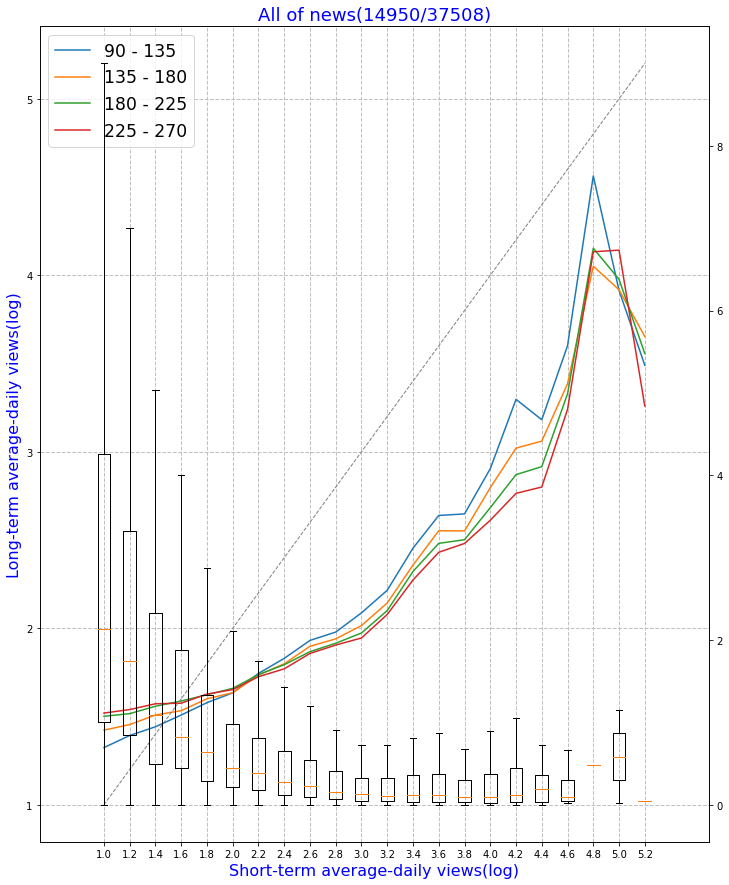

In [14]:
st = 2
fig = plt.figure(figsize=(12, 15))
title = "All of {}({}/{})".format(test_category, len(df_total_views_log.index), len(vids))
res, xs, yss = plot_fixed_window_bin_smooth(eval_days, df_total_views_log, vid_share_map, test_category, fig,\
                          title, average_daily=True, smooth_times = st, attr="views")
# plt.savefig('figs/shares/{}_st={}.png'.format(test_category, st), bbox_inches='tight')

In [ ]:
# area from one line to y=x diagnal
areas1 = []
for ys in yss:
    area = my_util.area_between_scatter_lines(xs, ys, xs)
    areas1.append(area)
# area between two lines
areas2 = []
for i in range(len(yss)-1):
    area = my_util.area_between_scatter_lines(yss[i], yss[i+1], xs)
    areas2.append(area)

In [ ]:
stat_path = "./stats/shares/smooth_times=2.csv"
line = test_category+","\
        +",".join(["{:.3f}".format(x) for x in areas1]) + ","\
        +",".join(["{:.3f}".format(x) for x in areas2])
with open(stat_path, "a") as f:
    f.write("{}\n".format(line))